# GE 461 Introduction to Data Science 2024

# Project 3 – Supervised Learning

### Görkem Kadir Solun 22003214

### Notes

Changing the random seeds affects the output.

You may need to update the data path.

You may need to update the figure sizes for pyplot.

You may need to update the output path.

### Imports


In [68]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# NOTE: Changing the random seeds affects the output.
random.seed(321)
np.random.seed(321)

### Loading and Processing the Data

I created raw, centered, and normalized data to use.


In [69]:
# Load the data
# NOTE: This data may need to be configured to the correct path
directory = os.getcwd()
train_data_path = os.path.join(directory, "data\\train1.txt")
test_data_path = os.path.join(directory, "data\\test1.txt")
output_path = os.path.join(directory, "output_gorkem\\")

train_data = np.loadtxt(train_data_path)
test_data = np.loadtxt(test_data_path)
all_data = np.concatenate((train_data, test_data), axis=0)

print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

# Get the mean of the all the data
all_data_mean = np.mean(all_data)
print("Mean: ", all_data_mean)

# Center the data
centered_data = all_data - all_data_mean
centered_train_data = train_data - all_data_mean
centered_test_data = test_data - all_data_mean

# Normalize the data
all_data_min = np.min(centered_data, axis=0)
all_data_max = np.max(centered_data, axis=0)
all_data_range = all_data_max - all_data_min
normalized_data = (centered_data - all_data_min) / all_data_range
normalized_train_data = (centered_train_data - all_data_min) / all_data_range
normalized_test_data = (centered_test_data - all_data_min) / all_data_range

Train Data Shape:  (60, 2)
Test Data Shape:  (41, 2)
Mean:  -14.43713867108911


### Plot Configurations


In [70]:
# Figure size configuration
# NOTE: This is a global configuration for all figures, you may need to adjust this
# NOTE: This change is permanent and will be iterated and applied every time you run this script
""" fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = fig_size[0] * 1.7
fig_size[1] = fig_size[1] * 1.7
plt.rcParams["figure.figsize"] = fig_size """

' fig_size = plt.rcParams["figure.figsize"]\nfig_size[0] = fig_size[0] * 1.7\nfig_size[1] = fig_size[1] * 1.7\nplt.rcParams["figure.figsize"] = fig_size '

# Artificial Neural Network

An ANN with one-dimensional input and output, having either one or no hidden layers.

Math behind my implementations

y = W @ X + B

dL/dW = (dL/dy) @ XT

dL/dB = (dL/dy)

dL/dX = (WT @ (dL/dy))

dL/dX = dL/dy \* sigmoid'(X)


In [71]:
# An ANN with one-dimensional input and output, having either one or no hidden layers.
class ArtificialNeuralNetwork:
    def __init__(self, hidden_layer_size=0):
        self.hidden_layer_size = hidden_layer_size
        self.output_bias = np.random.randn(1)

        # Initialize the weights and biases
        # If there is a hidden layer, initialize the weights and biases for both layers
        # If there is no hidden layer, initialize the weights and biases for the input-output layer

        # If there is a hidden layer (input-hidden-output)
        if hidden_layer_size != 0:
            self.input_hidden_weights = np.random.randn(1, hidden_layer_size)
            self.hidden_output_weights = np.random.randn(hidden_layer_size, 1)
            self.hidden_bias = np.random.randn(hidden_layer_size)
        # If there is no hidden layer (input-output)
        else:
            self.input_output_weights = np.random.randn(1, 1)

    # Sigmoid function for activation of the neurons in the network
    # sigmoid(X) = 1 / (1 + exp(-X))
    # The output of the sigmoid function is between 0 and 1 for all X
    # This function is used to normalize the output of the neurons
    # and to introduce non-linearity to the network
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    # Derivative of the sigmoid function
    # It is used to calculate the gradient of the loss function
    # with respect to the weights and biases of the network
    # It is used in the backpropagation algorithm to update the weights and biases
    # Sigmoid derivative is calculated as sigmoid(X) * (1 - sigmoid(X))
    def sigmoid_derivative(self, X):
        return X * (1 - X)

    # Sum of squared error loss function
    # The loss function is used to measure the difference between the predicted output
    # and the actual output of the networks
    def sum_squared_error(self, y_true, y_predicted, to_round=True):
        # Round the result to 0 decimal placess
        sum_squared_error = np.sum(np.square(y_true - y_predicted))
        return round(sum_squared_error, 0) if to_round else sum_squared_error

    # Forward pass of the network
    # The forward pass is used to calculate the output of the network
    def forward_propagation(self, X):
        # If there is a hidden layer
        # The output of the network is calculated as the input multiplied by the weights and added the bias
        # then passed through the sigmoid activation function
        # The output of the hidden layer is then multiplied by the weights and added the bias
        if self.hidden_layer_size != 0:
            self.hidden_layer_output = self.sigmoid(
                (X @ self.input_hidden_weights) + self.hidden_bias
            )
            self.output = (
                self.hidden_layer_output @ self.hidden_output_weights
            ) + self.output_bias
        # If there is no hidden layer
        # The output of the network is calculated as the input multiplied by the weights and added the bias
        else:
            self.output = np.dot(X, self.input_output_weights) + self.output_bias

        return self.output

    # Backward pass of the network
    # The backward pass is used to update the weights and biases of the network
    # It is used to minimize the loss function
    # The backpropagation algorithm is used to calculate the gradients of the loss function
    # with respect to the weights and biases of the network
    # The gradients are then used to update the weights and biases
    # The learning rate is used to control the step size of the updates to the weights and biases
    def backward_propagation(self, X, y, learning_rate=0.01):
        # Output error is calculated as sum of squared error loss function
        # The derivative of the loss function with respect to the output is calculated as
        output_error = -2 * (y - self.output)  # dL/dy

        # If there is a hidden layer
        # The backpropagation algorithm is used to calculate the gradients of the loss function
        # with respect to the weights and biases of the network
        # using the chain rule of calculus
        if self.hidden_layer_size != 0:
            # First calculate the gradient of the output-hidden layer, similar to the input-output layer
            hidden_output_weights_gradient = (
                self.hidden_layer_output.T @ output_error
            )  # dL/dW2
            hidden_output_bias_gradient = np.sum(output_error)  # dL/dB2

            # Then calculate the gradient of the hidden-input layer
            # by backpropagating the error from the output layer to the hidden layer
            hidden_output_error = (
                output_error @ self.hidden_output_weights.T
            )  # dE/dX = WT @ dE/dY

            # Then calculate the gradient of the hidden layer
            # by multiplying with the derivative of the sigmoid function
            # and the input of the hidden layer
            hidden_output_error = hidden_output_error * self.sigmoid_derivative(
                self.hidden_layer_output
            )  # dE/dX = dE/dy * sigmoid'(X)

            # Weight gradient is the dot product of the input and the error
            # as the derivative of the output with respect to the weights is the input
            input_hidden_weights_gradient = X.T @ hidden_output_error  # dL/dW1
            # Bias gradient is the sum of the error
            input_hidden_bias_gradient = np.sum(hidden_output_error)  # dL/dB1

            # Finally, update the weights and biases of the network
            # by multiplying the gradients with the learning rate
            self.hidden_output_weights -= hidden_output_weights_gradient * learning_rate
            self.output_bias -= hidden_output_bias_gradient * learning_rate
            self.input_hidden_weights -= input_hidden_weights_gradient * learning_rate
            self.hidden_bias -= input_hidden_bias_gradient * learning_rate

        # If there is no hidden layer
        else:
            # The derivative of the loss function with respect to the weights and bias of the input-output layer
            # is calculated as the derivative of the loss function with respect to the output
            # multiplied by the derivative of the output with respect to the weights and bias
            # The derivative of the output with respect to the weights is the input
            # The derivative of the output with respect to the bias is 1
            input_output_weights_gradient = X.T @ output_error  # dL/dW
            input_output_bias_gradient = np.sum(output_error)  # dL/dB

            # The weights and bias of the input-output layer are updated
            self.input_output_weights -= input_output_weights_gradient * learning_rate
            self.output_bias -= input_output_bias_gradient * learning_rate

        return output_error

    # Train the network
    # The training process is used to update the weights and biases of the network
    # using the stochastic gradient descent algorithm
    def train(self, X, y, epochs=10000, learning_rate=0.001):
        for epoch in range(epochs):
            # Stochastic Gradient Descent which chooses a random sample
            random_index = np.random.randint(len(X))

            # Get the random sample from the data
            # Reshape the data to be compatible with the network
            X_sample = X[random_index].reshape(-1, 1)
            y_sample = y[random_index].reshape(-1, 1)

            # Forward and Backward passes
            self.forward_propagation(X_sample)
            self.backward_propagation(X_sample, y_sample, learning_rate)

    # Predict the output of the network
    # The predict function is used to calculate the output of the network
    def predict(self, X):
        return self.forward_propagation(X)

    # Plot the data
    def plot(self, X, y, title="Data Plot"):
        X_values = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
        y_values = self.predict(X_values)

        plt.grid()
        plt.scatter(X, y, color="blue", label="Given Data")
        plt.plot(X_values, y_values, color="red", label="Predicted Data")
        plt.xlabel("X - Input")
        plt.ylabel("Y - Output")
        plt.title(title)
        plt.legend()

        plt.show()

# A - Comparing and Finding Configurations

### No hidden layer


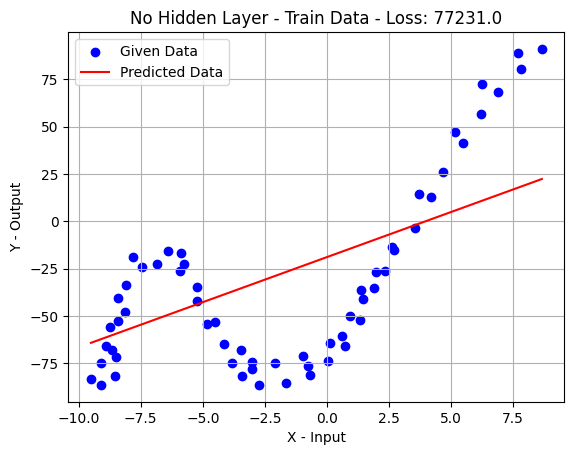

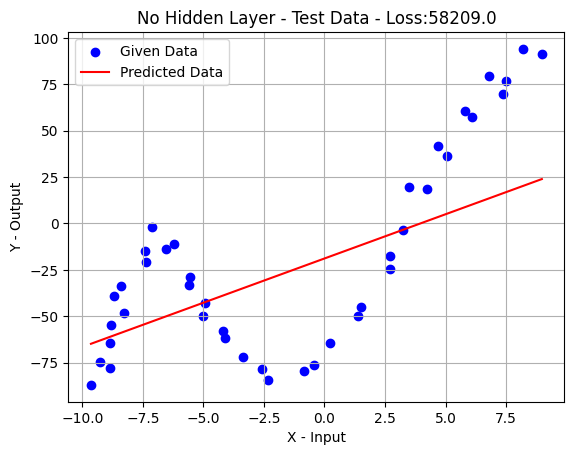

In [72]:
# Prepare the data for training
train_input = train_data[:, 0].reshape(-1, 1)
train_output = train_data[:, 1].reshape(-1, 1)
test_input = test_data[:, 0].reshape(-1, 1)
test_output = test_data[:, 1].reshape(-1, 1)

# Train the network with no hidden layer using the training data
artificialNeuralNetwork = ArtificialNeuralNetwork()
artificialNeuralNetwork.train(
    train_input,
    train_output,
)

# Plot the predicted output of the network with no hidden layer
artificialNeuralNetwork.plot(
    train_input, train_output, title=f"No Hidden Layer - Train Data - Loss: {
        artificialNeuralNetwork.sum_squared_error(train_output, artificialNeuralNetwork.predict(train_input))
        }"
)

artificialNeuralNetwork.plot(
    test_input, test_output, title=f"No Hidden Layer - Test Data - Loss:{
        artificialNeuralNetwork.sum_squared_error(test_output, artificialNeuralNetwork.predict(test_input))
    }"
)

### No Hidden Layer Normalized Data


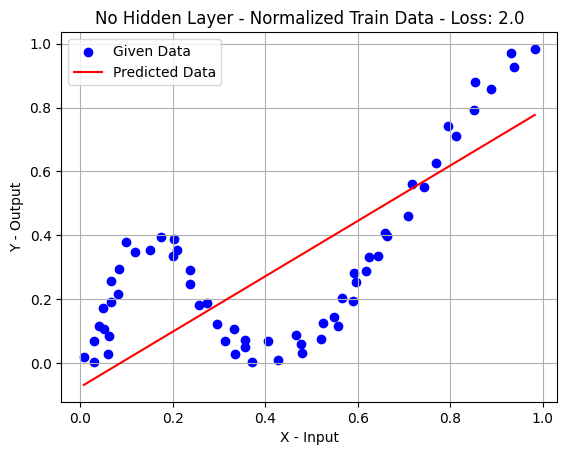

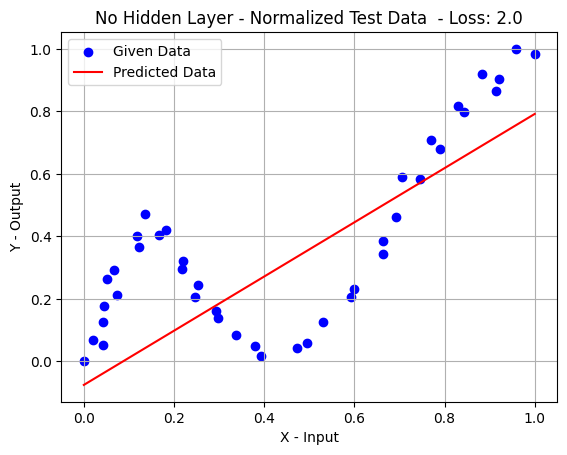

In [73]:
# Prepare the normalized data for training
train_input_normalized = normalized_train_data[:, 0].reshape(-1, 1)
train_output_normalized = normalized_train_data[:, 1].reshape(-1, 1)
test_input_normalized = normalized_test_data[:, 0].reshape(-1, 1)
test_output_normalized = normalized_test_data[:, 1].reshape(-1, 1)

# Train the network with no hidden layer using the normalized training data
artificialNeuralNetwork_normalized = ArtificialNeuralNetwork()
artificialNeuralNetwork_normalized.train(
    train_input_normalized,
    train_output_normalized,
)

# Plot the predicted output of the network with no hidden layer using the normalized data
artificialNeuralNetwork_normalized.plot(
    train_input_normalized,
    train_output_normalized,
    title=f"No Hidden Layer - Normalized Train Data - Loss: {
        artificialNeuralNetwork_normalized.sum_squared_error(train_output_normalized, artificialNeuralNetwork_normalized.predict(train_input_normalized))
        }",
)

artificialNeuralNetwork_normalized.plot(
    test_input_normalized,
    test_output_normalized,
    title=f"No Hidden Layer - Normalized Test Data  - Loss: {
        artificialNeuralNetwork_normalized.sum_squared_error(test_output_normalized, artificialNeuralNetwork_normalized.predict(test_input_normalized))
        }",
)

### One Hidden Layer ANN

Tested 2, 4, 8, 16, 32, 64, and 128 as hidden layer sizes, epochs are 10000, learning rate is 0.001


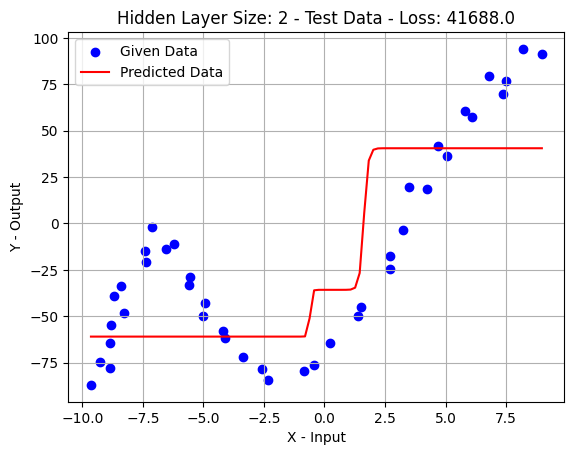

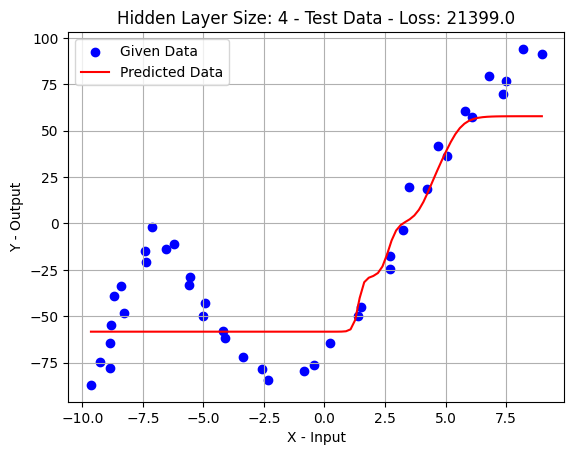

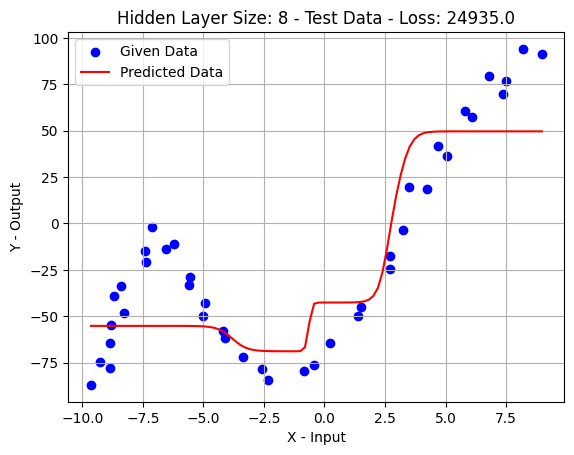

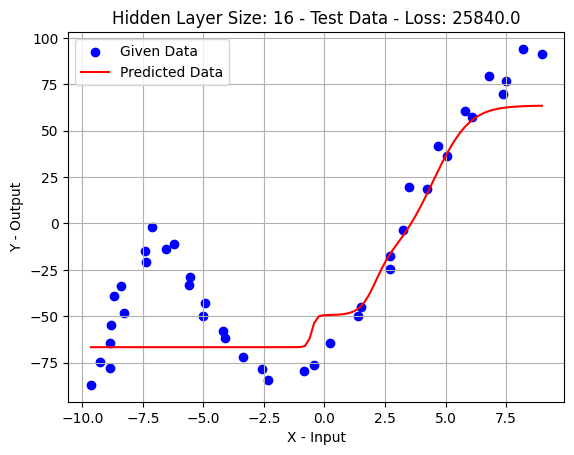

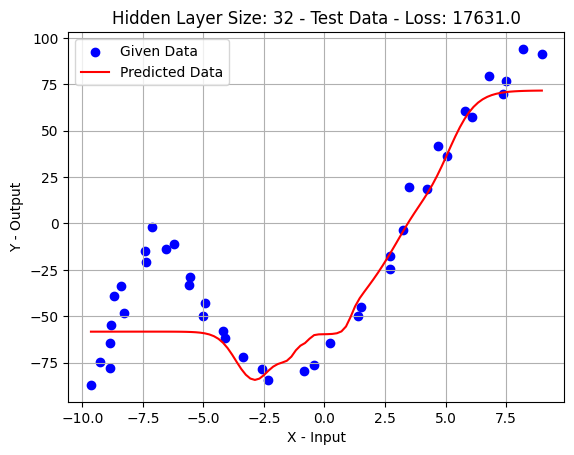

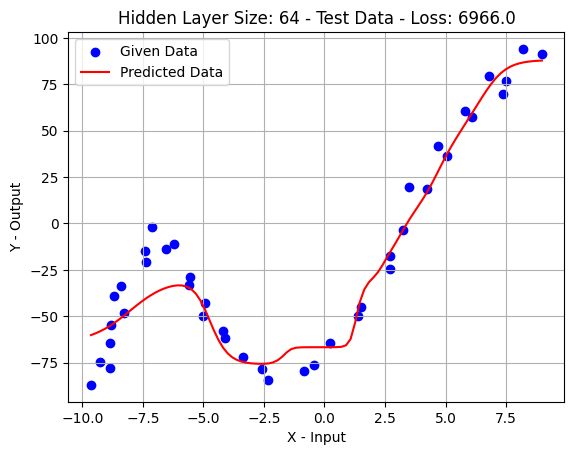

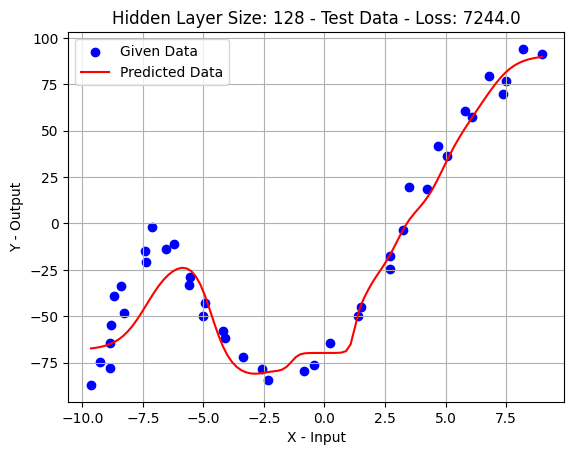

In [74]:
# Train the network with a hidden layer with different hidden layer sizes
hidden_layer_sizes = [2, 4, 8, 16, 32, 64, 128]
for hidden_layer_size in hidden_layer_sizes:
    artificialNeuralNetwork = ArtificialNeuralNetwork(hidden_layer_size=hidden_layer_size)

    # Train the network with a hidden layer using the training data
    artificialNeuralNetwork.train(
        train_input,
        train_output,
    )

    # Plot the predicted output of the network with a hidden layer
    """ artificialNeuralNetwork.plot(
        train_input,
        train_output,
        title=f"Hidden Layer Size: {hidden_layer_size} - Train Data - Loss: {
            artificialNeuralNetwork.sum_squared_error(train_output, artificialNeuralNetwork.predict(train_input))
            }",
    ) """

    artificialNeuralNetwork.plot(
        test_input,
        test_output,
        title=f"Hidden Layer Size: {hidden_layer_size} - Test Data - Loss: {
            artificialNeuralNetwork.sum_squared_error(test_output, artificialNeuralNetwork.predict(test_input))
            }",
    )

Tested 1000, 5000, 10000, 50000, 100000, and 500000 as epochs, hidden layer size is 32, learning rate is 0.001


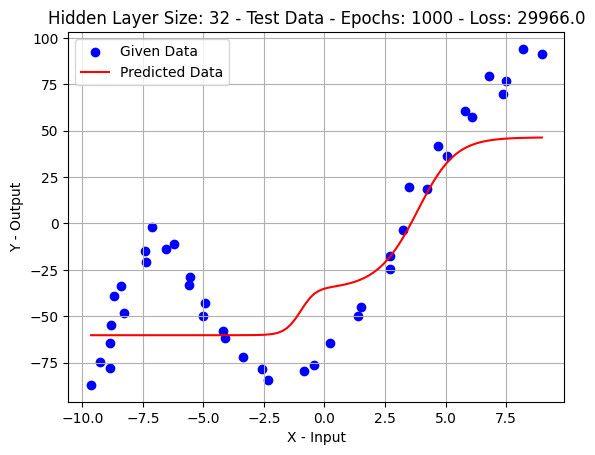

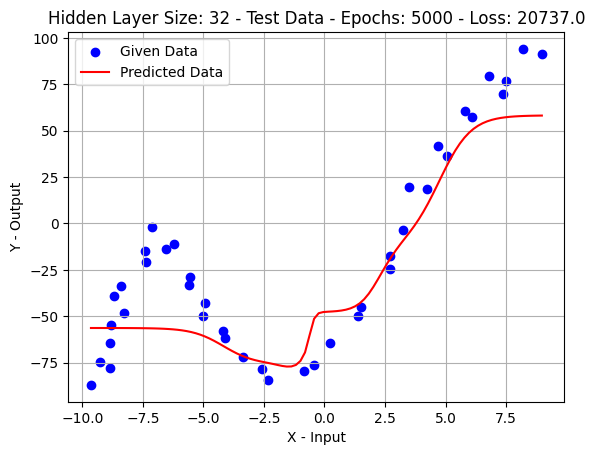

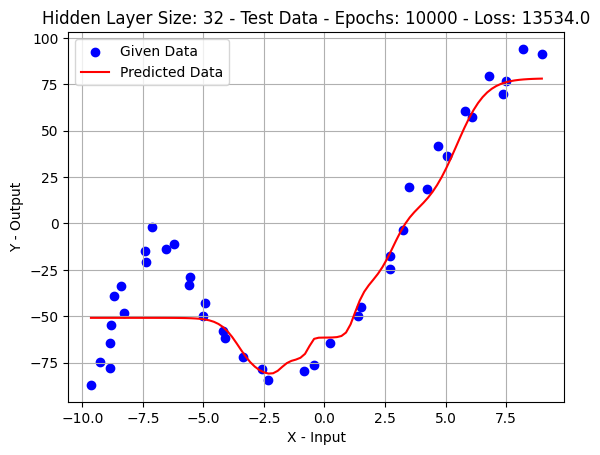

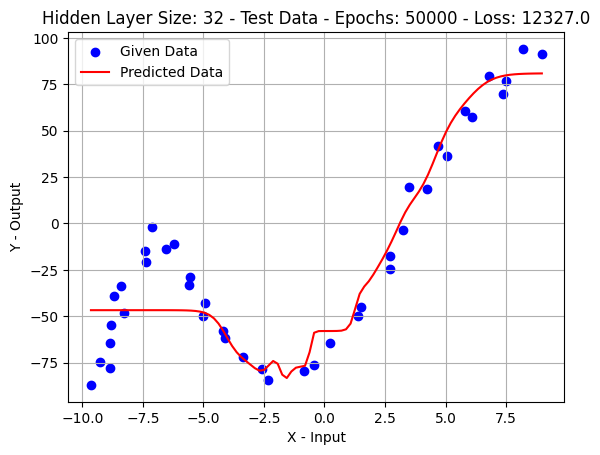

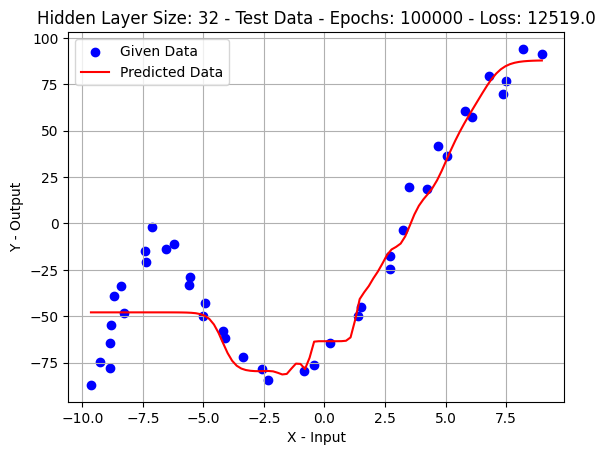

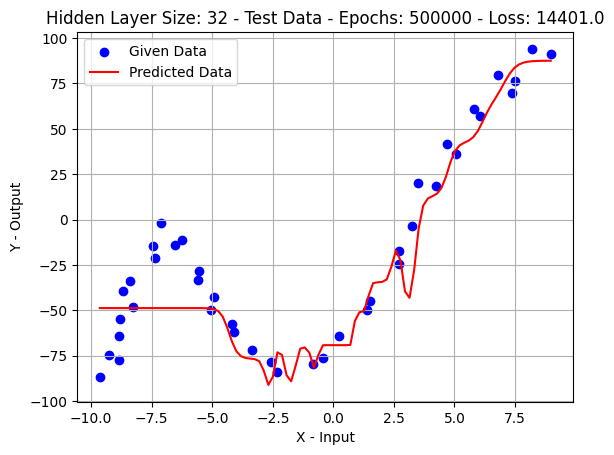

In [75]:
# Train the network with a hidden layer with different epochs
epochs = [1000, 5000, 10000, 50000, 100000, 500000]
for epoch in epochs:
    artificialNeuralNetwork = ArtificialNeuralNetwork(hidden_layer_size=32)

    # Train the network with a hidden layer using the training data
    artificialNeuralNetwork.train(
        train_input,
        train_output,
        epochs=epoch,
    )

    # Plot the predicted output of the network with a hidden layer
    """ artificialNeuralNetwork.plot(
        train_input,
        train_output,
        title=f"Hidden Layer Size: 32 - Train Data - Epochs: {epoch} - Loss: {
            artificialNeuralNetwork.sum_squared_error(train_output, artificialNeuralNetwork.predict(train_input))
            }",
    ) """
    
    artificialNeuralNetwork.plot(
        test_input,
        test_output,
        title=f"Hidden Layer Size: 32 - Test Data - Epochs: {epoch} - Loss: {
            artificialNeuralNetwork.sum_squared_error(test_output, artificialNeuralNetwork.predict(test_input))
            }",
    )

Tested 0.01, 0.005, 0.001, 0.0005, and 0.0001 as learning rates, epochs are 10000, hidden layer size is 32


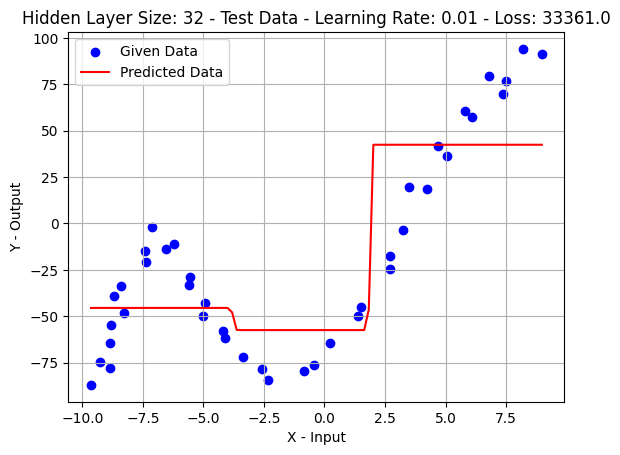

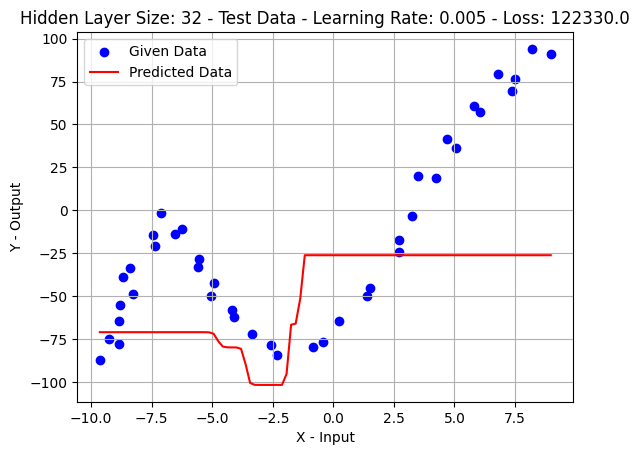

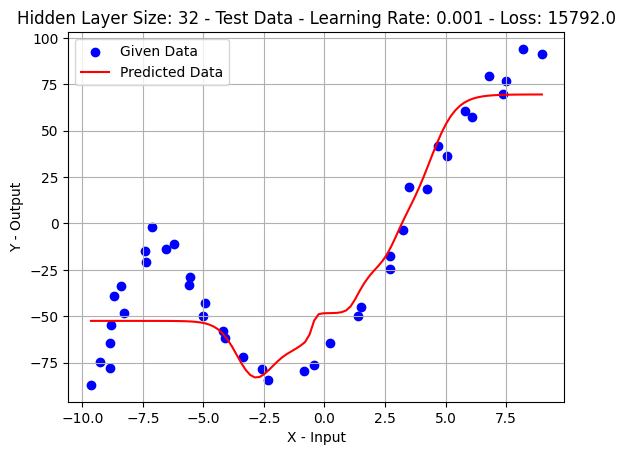

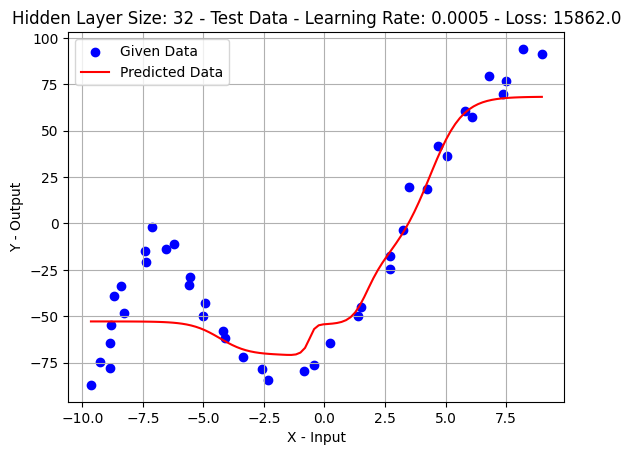

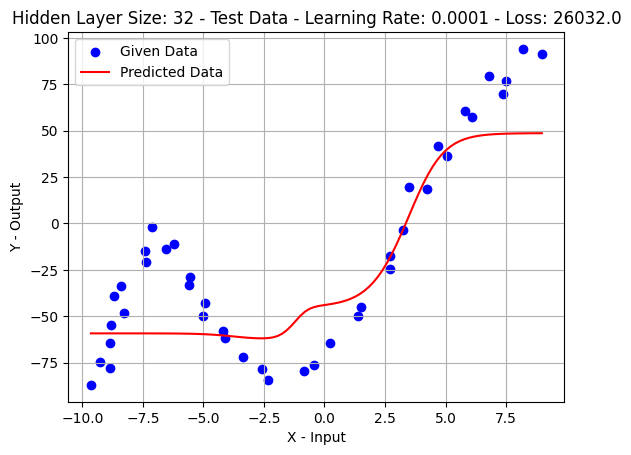

In [76]:
# Train the network with a hidden layer with learning rates
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
for learning_rate in learning_rates:
    artificialNeuralNetwork = ArtificialNeuralNetwork(hidden_layer_size=32)
    
    # Train the network with a hidden layer using the training data
    artificialNeuralNetwork.train(
        train_input,
        train_output,
        learning_rate=learning_rate,
    )
    
    # Plot the predicted output of the network with a hidden layer  
    """ artificialNeuralNetwork.plot(
        train_input,
        train_output,
        title=f"Hidden Layer Size: 32 - Train Data - Learning Rate: {learning_rate} - Loss: {
            artificialNeuralNetwork.sum_squared_error(train_output, artificialNeuralNetwork.predict(train_input))
            }",
    ) """
    
    artificialNeuralNetwork.plot(
        test_input,
        test_output,
        title=f"Hidden Layer Size: 32 - Test Data - Learning Rate: {learning_rate} - Loss: {
            artificialNeuralNetwork.sum_squared_error(test_output, artificialNeuralNetwork.predict(test_input))
            }",
    )   

Tested normalized data vs raw data, epochs are 500000, learning rate is 0.001, hidden layer size is 128


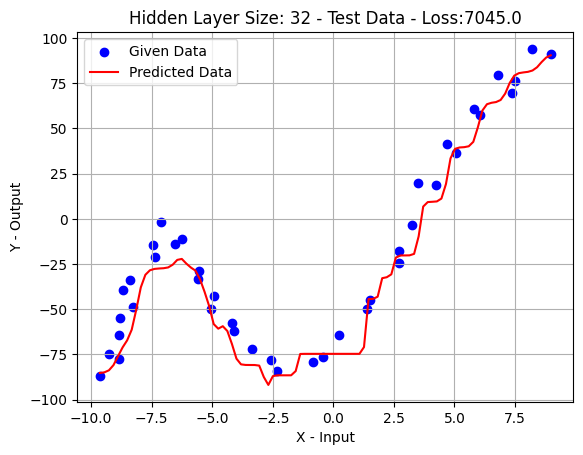

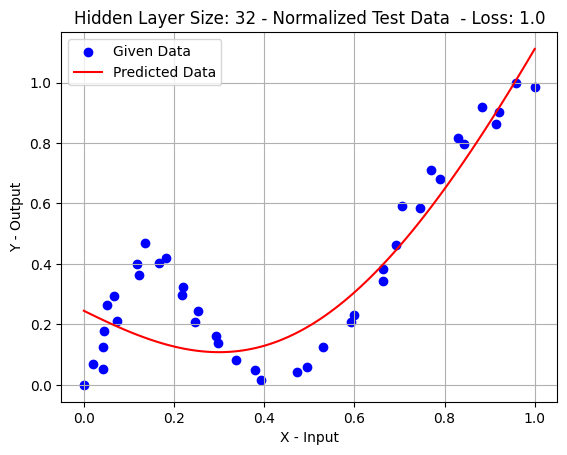

In [77]:
# Train the network with no hidden layer using the training data
artificialNeuralNetwork = ArtificialNeuralNetwork(128)
artificialNeuralNetwork.train(
    train_input,
    train_output,
    epochs=500000,
)

# Plot the predicted output of the network with no hidden layer
""" artificialNeuralNetwork.plot(
    train_input, train_output, title=f"Hidden Layer Size: 32 - Train Data - Loss: {
        artificialNeuralNetwork.sum_squared_error(train_output, artificialNeuralNetwork.predict(train_input))
        }"
) """

artificialNeuralNetwork.plot(
    test_input, test_output, title=f"Hidden Layer Size: 32 - Test Data - Loss:{
        artificialNeuralNetwork.sum_squared_error(test_output, artificialNeuralNetwork.predict(test_input))
    }"
)

# Train the network with no hidden layer using the normalized training data
artificialNeuralNetwork_normalized = ArtificialNeuralNetwork(128)
artificialNeuralNetwork_normalized.train(
    train_input_normalized,
    train_output_normalized,
    epochs=500000,
)

# Plot the predicted output of the network with no hidden layer using the normalized data
""" artificialNeuralNetwork_normalized.plot(
    train_input_normalized,
    train_output_normalized,
    title=f"Hidden Layer Size: 32 - Normalized Train Data - Loss: {
        artificialNeuralNetwork_normalized.sum_squared_error(train_output_normalized, artificialNeuralNetwork_normalized.predict(train_input_normalized))
        }",
) """

artificialNeuralNetwork_normalized.plot(
    test_input_normalized,
    test_output_normalized,
    title=f"Hidden Layer Size: 32 - Normalized Test Data  - Loss: {
        artificialNeuralNetwork_normalized.sum_squared_error(test_output_normalized, artificialNeuralNetwork_normalized.predict(test_input_normalized))
        }",
)

# Part B

### Selected Model

Hidden layer size is 128, epochs are 50000, learning rate is 0.001, weights are distributed with Gaussian Distribution with mean 0 and variance 1, stopped when epochs are finished, not normalized data(raw)


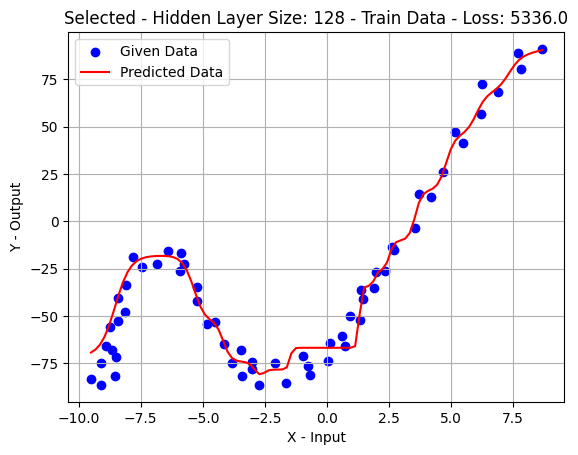

Train Data Loss:  5336.278192495982


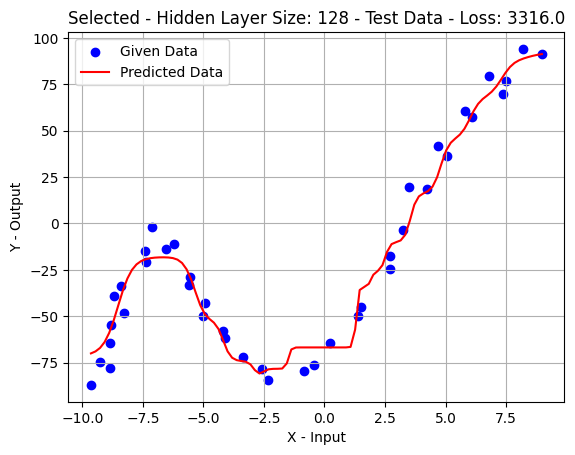

Test Data Loss:  3315.8063709024023


In [78]:
# Train the selected network with the raw training data
artificialNeuralNetwork = ArtificialNeuralNetwork(hidden_layer_size=128)
artificialNeuralNetwork.train(
    train_input,
    train_output,
    epochs=50000,
    learning_rate=0.001,
)

# Plot the predicted output of the network with the raw training data
artificialNeuralNetwork.plot(
    train_input,
    train_output,
    title=f"Selected - Hidden Layer Size: 128 - Train Data - Loss: {
        artificialNeuralNetwork.sum_squared_error(train_output, artificialNeuralNetwork.predict(train_input))
        }",
)   

print("Train Data Loss: ", artificialNeuralNetwork.sum_squared_error(train_output, artificialNeuralNetwork.predict(train_input ), False))   

artificialNeuralNetwork.plot(
    test_input,
    test_output,
    title=f"Selected - Hidden Layer Size: 128 - Test Data - Loss: {
        artificialNeuralNetwork.sum_squared_error(test_output, artificialNeuralNetwork.predict(test_input))
        }",
)

print   ("Test Data Loss: ", artificialNeuralNetwork.sum_squared_error(test_output, artificialNeuralNetwork.predict(test_input ), False))

# Part C

Created two different configurations for different hidden layer sizes

1. Epochs = 50000, Learning Rate = 0.001, raw data
2. Epochs = 100000, Learning Rate = 0.0005, raw data


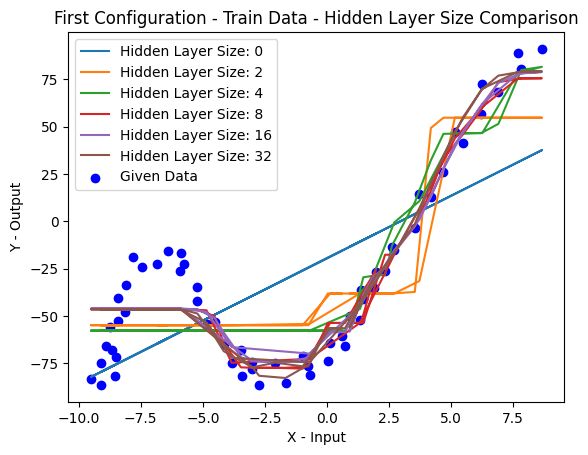

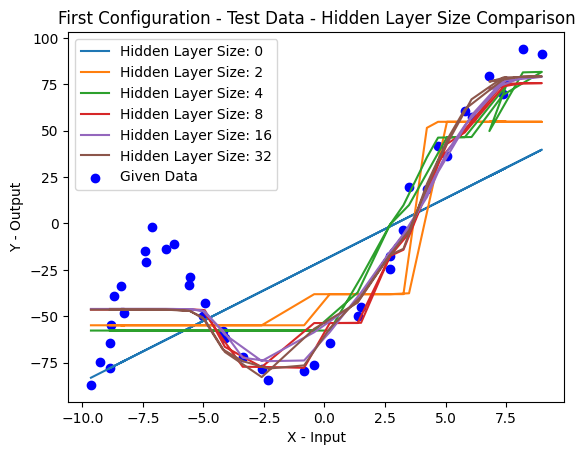

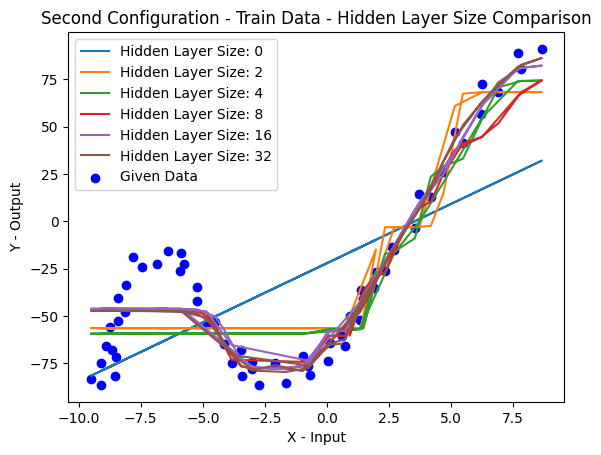

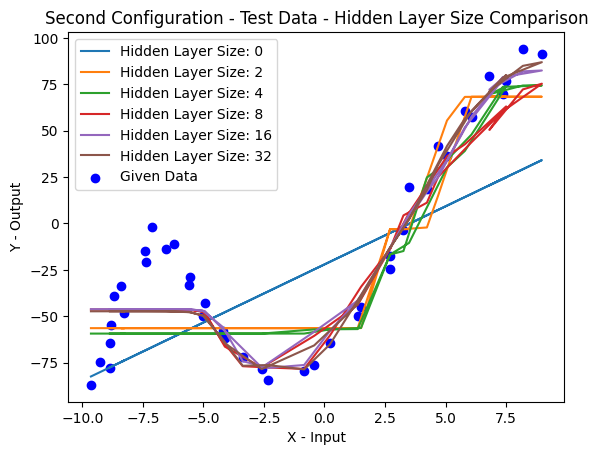

   Hidden Layer Size  Train First Loss Mean  Train First Loss Std  \
0                  0            1192.766255            999.795587   
1                  2             554.416474            480.623431   
2                  4             363.609614            435.587592   
3                  8             235.315270            362.673699   
4                 16             226.448878            366.413829   
5                 32             225.247079            365.192155   

   Test First Loss Mean  Test First Loss Std  Train Second Loss Mean  \
0           1337.362473          1136.573123             1190.697932   
1            703.964449           753.626750              394.189404   
2            496.715883           670.707029              362.011535   
3            318.372856           479.322391              247.783536   
4            303.834865           475.647482              221.701399   
5            311.440128           476.784012              212.266103   

   Train Se

In [79]:
# Now try differet hidden layer sizes with two different configurations
# 1. Epochs = 50000, Learning Rate = 0.001, raw data
# 2. Epochs = 100000, Learning Rate = 0.0005, raw data
hidden_layer_sizes = [0, 2, 4, 8, 16, 32]

# For the first configuration
train_first_outputs_every_hidden_layer_size = []
test_first_outputs_every_hidden_layer_size = []
# For the second configuration
train_second_outputs_every_hidden_layer_size = []
test_second_outputs_every_hidden_layer_size = []

# Gather the results for each hidden layer size for both configurations of the network
for hidden_layer_size in hidden_layer_sizes:
    # Train the network with the first configuration
    artificialNeuralNetwork = ArtificialNeuralNetwork(
        hidden_layer_size=hidden_layer_size
    )
    artificialNeuralNetwork.train(
        train_input,
        train_output,
        epochs=50000,
        learning_rate=0.001,
    )

    # Append the train and test data output and loss to the lists
    train_input_result = artificialNeuralNetwork.predict(train_input)
    train_first_outputs_every_hidden_layer_size.append(train_input_result)
    test_input_result = artificialNeuralNetwork.predict(test_input)
    test_first_outputs_every_hidden_layer_size.append(test_input_result)

    # Train the network with the second configuration
    artificialNeuralNetwork = ArtificialNeuralNetwork(
        hidden_layer_size=hidden_layer_size
    )
    artificialNeuralNetwork.train(
        train_input,
        train_output,
        epochs=100000,
        learning_rate=0.0005,
    )

    # Append the train and test data output and loss to the lists
    train_input_result = artificialNeuralNetwork.predict(train_input)
    train_second_outputs_every_hidden_layer_size.append(train_input_result)
    test_input_result = artificialNeuralNetwork.predict(test_input)
    test_second_outputs_every_hidden_layer_size.append(test_input_result)


# Print the losses of the networks with different hidden layer sizes for both configurations
def plot_outputs(plot_outputs, title, scatter_input, scatter_output):
    plt.figure()
    for i, output in enumerate(plot_outputs):
        plt.plot(
            scatter_input, output, label=f"Hidden Layer Size: {hidden_layer_sizes[i]}"
        )
    plt.scatter(scatter_input, scatter_output, color="blue", label="Given Data")
    plt.xlabel("X - Input")
    plt.ylabel("Y - Output")
    plt.title(title)
    plt.legend()
    plt.show()


# Plot the outputs of the networks with different hidden layer sizes for both configurations
plot_outputs(
    train_first_outputs_every_hidden_layer_size,
    "First Configuration - Train Data - Hidden Layer Size Comparison",
    train_input,
    train_output,
)

plot_outputs(
    test_first_outputs_every_hidden_layer_size,
    "First Configuration - Test Data - Hidden Layer Size Comparison",
    test_input,
    test_output,
)

plot_outputs(
    train_second_outputs_every_hidden_layer_size,
    "Second Configuration - Train Data - Hidden Layer Size Comparison",
    train_input,
    train_output,
)

plot_outputs(
    test_second_outputs_every_hidden_layer_size,
    "Second Configuration - Test Data - Hidden Layer Size Comparison",
    test_input,
    test_output,
)

# Calculate the losses of the networks with different hidden layer sizes for both configurations
train_first_losses = []
train_first_losses_means = []
train_first_losses_stds = []

test_first_losses = []
test_first_losses_means = []
test_first_losses_stds = []

train_second_losses = []
train_second_losses_means = []
train_second_losses_stds = []

test_second_losses = []
test_second_losses_means = []
test_second_losses_stds = []

# Calculate the losses of every hidden layer size for both configurations
for i, hidden_layer_size in enumerate(hidden_layer_sizes):
    train_first_losses.append(
        np.square(train_first_outputs_every_hidden_layer_size[i] - train_output)
    )
    test_first_losses.append(
        np.square(test_first_outputs_every_hidden_layer_size[i] - test_output)
    )
    train_second_losses.append(
        np.square(train_second_outputs_every_hidden_layer_size[i] - train_output)
    )
    test_second_losses.append(
        np.square(test_second_outputs_every_hidden_layer_size[i] - test_output)
    )

    train_first_losses_means.append(np.mean(train_first_losses[i]))
    train_first_losses_stds.append(np.std(train_first_losses[i]))

    test_first_losses_means.append(np.mean(test_first_losses[i]))
    test_first_losses_stds.append(np.std(test_first_losses[i]))

    train_second_losses_means.append(np.mean(train_second_losses[i]))
    train_second_losses_stds.append(np.std(train_second_losses[i]))

    test_second_losses_means.append(np.mean(test_second_losses[i]))
    test_second_losses_stds.append(np.std(test_second_losses[i]))


# Prepare a table for the losses of the networks with different hidden layer sizes for both configurations
# for each hidden layer size
table_data = {
    "Hidden Layer Size": hidden_layer_sizes,
    "Train First Loss Mean": train_first_losses_means,
    "Train First Loss Std": train_first_losses_stds,
    "Test First Loss Mean": test_first_losses_means,
    "Test First Loss Std": test_first_losses_stds,
    "Train Second Loss Mean": train_second_losses_means,
    "Train Second Loss Std": train_second_losses_stds,
    "Test Second Loss Mean": test_second_losses_means,
    "Test Second Loss Std": test_second_losses_stds,
}

print(pd.DataFrame(table_data))